# Data Cleaning and Preprocessing

In [70]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import random
random.seed(10)

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import spacy
from wordcloud import WordCloud

In [3]:
citation = pd.read_csv("citation_sample.csv")

In [4]:
citation.head()

,index,title,authors,year,venue,id,references,abstract,ISCITED_COUNT,AUTHOR_COUNT,REF_COUNT,MAIN_AUTHOR,SECONDARY_AUTHORS,TITLE_TOKEN,ABSTRACT_TOKEN
0,1048548,Securing communication using function extracti...,['K. Vimal Kumar'],2009,Computers Security,1587640,[],NaN,0,1,0,K. Vimal Kumar,[],"['securing', 'communication', 'using', 'functi...",[]
1,617841,Compressing Data Cube in Parallel OLAP Systems,"['Frank K. H. A. Dehne', 'Todd Eavis', 'Boyong...",2007,Data Science Journal,839971,[],NaN,0,3,0,Frank K. H. A. Dehne,"['Todd Eavis', 'Boyong Liang']","['compressing', 'data', 'cube', 'in', 'paralle...",[]
2,804336,Distributed Resource Administration Using Cfen...,"['Mark Burgess', 'Ricky Ralston']",1997,Softw Pract Exper,1073637,[],NaN,15,2,0,Mark Burgess,['Ricky Ralston'],"['distributed', 'resource', 'administration', ...",[]
3,960506,Existence of positive solutions of BVPs for se...,"['Wan-Tong Li', 'Ming-Fei Niu', 'Jian-Ping Sun']",2004,Applied Mathematics and Computation,1280289,[],NaN,0,3,0,Wan-Tong Li,"['Ming-Fei Niu', 'Jian-Ping Sun']","['existence', 'of', 'positive', 'solutions', '...",[]
4,710912,Integrating Searching and Authoring in Mizar,"['Paul A. Cairns', 'Jeremy Gow']",2007,J Autom Reasoning,955214,"['595127', '954818', '612606', '893021', '5009...",The vision of a computerized assistant to math...,0,2,10,Paul A. Cairns,['Jeremy Gow'],"['integrating', 'searching', 'and', 'authoring...","['the', 'vision', 'of', 'a', 'computerized', '..."


In [5]:
del citation["index"]

In [6]:
labels = citation[["TITLE_TOKEN", "ABSTRACT_TOKEN"]]
labels = labels.apply(lambda row: "".join(row.dropna()), axis=1)

In [7]:
labels = labels.apply(lambda row: row.replace("[", ""))
labels = labels.apply(lambda row: row.replace("]", ""))
labels = labels.apply(lambda row: row.replace("\'", ""))
labels = labels.apply(lambda row: row.replace(",", ""))

In [8]:
labels

0        securing communication using function extracti...
1           compressing data cube in parallel olap systems
2        distributed resource administration using cfen...
3        existence of positive solutions of bvps for se...
4        integrating searching and authoring in mizarth...
                               ...                        
12096                                            editorial
12097    hdr image compression by local adaptation for ...
12098    quantifying and setting off network performanc...
12099    hardwaremeasurements of storage access conflic...
12100    detection and segmentation of touching charact...
Length: 12101, dtype: object

In [20]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower() # Convert to lower cases
        text = re.sub(r'[\n\r\t]+', ' ', text) # Remove newline characters and tabs, replace with a space
        #text = re.sub(r'[^\w\s\']', '', text) # Remove punctuation (consider apostrophes for contractions)
        text = re.sub(r'\d+', '', text) # Remove digits
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces

        tokens = word_tokenize(text)
        irrelevant = ["special", "issue", "news", "problem", "problems", "time",
                     "new", "use", "note", "city", "books", "multiple", "many", "aspects",
                     "book", "guest", "von", "der", "und", "zur", "mit"]
        
        tokens = [word for word in tokens if word not in stopwords.words('english') and word not in irrelevant]


        # POS tagging
        tagged = pos_tag(tokens)

        # Keep only nouns: NN (singular noun), NNS (plural noun), NNP (proper noun, singular), NNPS (proper noun, plural)
        nouns = [word for word, pos in tagged if pos in ('NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS')]

        text = ' '.join(nouns)

    elif isinstance(text, float) and np.isnan(text):
        return ''
    else:
        return ''
    return text

In [21]:
def clean_text_and_combine_adj_noun(text):
    if isinstance(text, str):
        text = text.lower()

        text = re.sub(r'[\n\r\t]+', ' ', text)
        #text = re.sub(r'[^\w\s\']', '', text)
        #text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()

        tokens = word_tokenize(text)
        # Filter out stopwords (can be removed if you want to include all words)
        # clean something irrelevant
        irrelevant = ["special", "issue", "news", "problem", "problems", "time",
                     "new", "use", "note", "city", "books", "multiple", "many", "aspects",
                     "book", "guest", "von", "der", "und", "zur", "mit"]
        
        tokens = [word for word in tokens if word not in stopwords.words('english') and word not in irrelevant]


        # POS tagging
        tagged = pos_tag(tokens)

        # Iterate through tagged tokens and concatenate adjective with noun if adjacent
        combined_tokens = []
        skip_next = False
        for i, (word, pos) in enumerate(tagged):
            if skip_next:
                skip_next = False
                continue

            # # clean something related to the job title
            # if "electric" in word or "nuclear" in word or "engineer" in word:
            #     continue

            if pos in ('JJ', 'JJR', 'JJS') and i+1 < len(tagged) and tagged[i+1][1] in ('NN', 'NNS', 'NNP', 'NNPS'):
                combined_word = word + '_' + tagged[i+1][0]  # Concatenate adjective and noun
                combined_tokens.append(combined_word)
                skip_next = True  # Skip the next word since it's already concatenated
            elif pos in ('NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'):
                combined_tokens.append(word)  # Keep nouns and adjectives not followed by a noun

        text = ' '.join(combined_tokens)

    elif isinstance(text, float) and np.isnan(text):
        return ''
    else:
        return ''
    return text



In [11]:
nlp = spacy.load("en_core_web_sm")

def clean_text_phrases(text):
    if isinstance(text, str):
        text = text.lower() # Convert to lower cases
        text = re.sub(r'[\n\r\t]+', ' ', text) # Remove newline characters and tabs, replace with a space
        text = re.sub(r'\d+', '', text) # Remove digits
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces

        doc = nlp(text)
        irrelevant = ["special", "issue", "news", "problem", "problems", "time",
                     "new", "use", "note", "city", "books", "multiple", "many", "aspects",
                     "book", "guest", "von", "der", "und", "zur", "mit"]
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and not token.is_space
                 and token not in irrelevant]

        text = ' '.join(tokens)

    elif isinstance(text, float) and np.isnan(text):
        return ''
    else:
        return ''
    return text

In [22]:
labels_clean = labels.apply(clean_text)

In [23]:
labels_clean_with_phrases = labels.apply(clean_text_phrases)

In [23]:
labels_clean_adj_nouns = labels.apply(clean_text_and_combine_adj_noun)

In [24]:
labels_clean

0        communication function extraction technology m...
1                          data cube parallel olap systems
2                         resource administration cfengine
3        existence positive solutions secondorder nonli...
4        mizarthe vision assistant mathematicians incep...
                               ...                        
12096                                            editorial
12097    hdr image compression local adaptation scene d...
12098    network performancewhile network collaboration...
12099    hardwaremeasurements storage access conflicts ...
12100    detection segmentation characters mathematical...
Length: 12101, dtype: object

In [24]:
labels_clean_with_phrases

0        securing communication function extraction tec...
1              compressing data cube parallel olap systems
2             distributed resource administration cfengine
3        existence positive solutions bvps secondorder ...
4        integrating searching authoring mizarthe visio...
                               ...                        
12096                                            editorial
12097    hdr image compression local adaptation scene d...
12098    quantifying setting network performancewhile a...
12099    hardwaremeasurements storage access conflicts ...
12100    detection segmentation touching characters mat...
Length: 12101, dtype: object

In [25]:
labels_clean_adj_nouns

0        communication function_extraction technology m...
1                          data cube parallel_olap systems
2                         resource administration cfengine
3        existence positive_solutions secondorder nonli...
4        mizarthe_vision assistant_mathematicians incep...
                               ...                        
12096                                            editorial
12097    hdr_image compression local_adaptation scene d...
12098    network performancewhile_network collaboration...
12099    hardwaremeasurements storage_access conflicts ...
12100    detection segmentation characters mathematical...
Length: 12101, dtype: object

# LDA Topic Modeling

In [33]:
# Vectorization
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words="english")
X_count = vectorizer.fit_transform(labels_clean_adj_nouns)

# Materialize the sparse data
data_dense = X_count.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.3548645349444848 %


In [34]:
# Vectorization
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words="english")
X_tfidf = vectorizer.fit_transform(labels_clean_adj_nouns)


# Materialize the sparse data
data_dense = X_tfidf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.08711795058577333 %


## X_tfidf

In [35]:
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6, 7, 8],
                'learning_decay': [0.1, 0.3, 0.7]}

# Init the Model
lda = LatentDirichletAllocation(random_state = 0,
                                max_iter = 10,
                                batch_size = 256)

# Init Grid Search Class
lda_model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
lda_model.fit(X_tfidf)

GridSearchCV(estimator=LatentDirichletAllocation(batch_size=256,
                                                 random_state=0),
             param_grid={'learning_decay': [0.1, 0.3, 0.7],
                         'n_components': [2, 3, 4, 5, 6, 7, 8]})

In [36]:
# Best Model
best_lda_model = lda_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_tfidf))

Best Model's Params:  {'learning_decay': 0.1, 'n_components': 2}
Best Log Likelihood Score:  -59719.45318656971
Model Perplexity:  7633.051091581197


In [37]:
# Applying LDA
lda = LatentDirichletAllocation(n_components=2,               # Number of topics
                                max_iter=10,               # Max learning iterations
                                learning_decay = 0.1,
                                random_state=0,          # Random state
                                batch_size=256)
lda.fit(X_tfidf)

# Displaying the top words in each topic

topics = []
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        topics.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(f"Topic {topic_idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 50
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
networks, systems, data, analysis, network, performance, method, management, algorithm, methods, framework, service, wireless, optimization, communication, sensor, detection, protocol, efficient, techniques, estimation, architecture, scheme, complexity, paper, services, neural_networks, trees, function, traffic, approach, number, comparison, power, resource, mechanism, protocols, functions, evaluation, multimedia, codes, constraints, case, structure, simulation, allocation, access, results, strategies, semantics
Topic 2:
model, design, information, software, control, approach, systems, models, image, application, development, applications, process, data, knowledge, theory, paper, recognition, web, retrieval, research, graphs, language, analysis, security, computer, classification, support, engineering, images, environment, graph, processing, programs, study, database, implementation, method, technology, tools, integration, results, tool, decision, video, algorithms, users, bus

## X_count

In [38]:
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6, 7, 8],
                'learning_decay': [0.1, 0.3, 0.7]}

# Init the Model
lda = LatentDirichletAllocation(random_state = 0,
                                max_iter = 10,
                                batch_size = 256)

# Init Grid Search Class
lda_model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
lda_model.fit(X_count)

GridSearchCV(estimator=LatentDirichletAllocation(batch_size=256,
                                                 random_state=0),
             param_grid={'learning_decay': [0.1, 0.3, 0.7],
                         'n_components': [2, 3, 4, 5, 6, 7, 8]})

In [39]:
# Best Model
best_lda_model = lda_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_count))

Best Model's Params:  {'learning_decay': 0.1, 'n_components': 2}
Best Log Likelihood Score:  -147432.8500067238
Model Perplexity:  965.6832830752367


In [40]:
# Applying LDA
lda = LatentDirichletAllocation(n_components=2,               # Number of topics
                                max_iter=10,               # Max learning iterations
                                learning_decay = 0.1,
                                random_state=0,          # Random state
                                batch_size=256)
lda.fit(X_count)

# Displaying the top words in each topic

topics = []
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        topics.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(f"Topic {topic_idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 50
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
confusion, approachin, changes, belongs, computational_cost, aqueous_solubility, accurate, breach, cloud, continuoustime, accurate_model, component_analysis, component, assumption, bypass, conference, communities, achievement, biomedical_literature, accuracy_efficiency, cooccurrence, concrete_frames, biometrics, autonomous_systems, bytecode, behalf, algorithmic_approaches, algebraic, answer, adopt, communicative_action, accommodate, connectivity, considerations, constant_factor, chemicals, comprehensive_evaluation, complex_functions, comparative_analysis, constant, associate, coalgebraic, address_shortcomings, agility, continuous_data, anticipate, coarse, analyses, better_performance, abstracts
Topic 2:
answer, buffer, bypass, card, changes, accommodate, acceptable_region, cards, chemicals, analytical_framework, accurate_model, comparative_analysis, bugs, bearing, connectionist, acceptance, categories, connection, bytecode, complete_system, autoregressive, certain, computation

# BERT Topic modeling

In [1]:
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic

In [26]:
start_time = dt.datetime.now()

#docs = exp_summary_bert
docs = labels_clean

topic_model = BERTopic(verbose=True,
                       embedding_model="paraphrase-MiniLM-L12-v2",
                       min_topic_size=30,  # Adjusted for finer granularity
                       n_gram_range=(1, 2),  # To capture phrases
                       nr_topics='auto',  # Keep dynamic topic number
                       low_memory=False  # Based on your system's memory capacity
                      )
topics, _ = topic_model.fit_transform(docs); len(topic_model.get_topic_info())
end_time = dt.datetime.now()
elapsed_time = end_time - start_time

2024-04-22 12:51:20,351 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/379 [00:00<?, ?it/s]

2024-04-22 12:52:35,720 - BERTopic - Embedding - Completed ✓
2024-04-22 12:52:35,721 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-22 12:52:40,371 - BERTopic - Dimensionality - Completed ✓
2024-04-22 12:52:40,372 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-22 12:52:40,841 - BERTopic - Cluster - Completed ✓
2024-04-22 12:52:40,841 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-22 12:52:41,746 - BERTopic - Representation - Completed ✓
2024-04-22 12:52:41,747 - BERTopic - Topic reduction - Reducing number of topics
2024-04-22 12:52:42,663 - BERTopic - Topic reduction - Reduced number of topics from 40 to 7


In [27]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4289,-1_systems_system_analysis_data,"[systems, system, analysis, data, model, appro...",[architecture multichannel adaptive informatio...
1,0,7235,0_paper_system_data_model,"[paper, system, data, model, information, syst...",[functionality multifunctional software system...
2,1,236,1_robot_control_robots_motion,"[robot, control, robots, motion, robotic, auto...",[flexible architecture navigation control mobi...
3,2,138,2_editorial_preface_editorial editorial_prefac...,"[editorial, preface, editorial editorial, pref...","[editorial, editorial, editorial]"
4,3,88,3_speech_recognition_music_speech recognition,"[speech, recognition, music, speech recognitio...",[missingfeature speech recognition simultaneou...
5,4,61,4_ultrasound_ct_images_mri,"[ultrasound, ct, images, mri, imaging, medical...","[patchbased nonlocal mri ultrasound images, fo..."
6,5,54,5_games_game_tournaments_team,"[games, game, tournaments, team, chess, nash, ...",[pure nash equilibria games large number actio...


In [85]:
topic_model.get_topic(-1)

[('system', 0.017378753626110455),
 ('analysis', 0.016418841748130436),
 ('data', 0.014279597796696825),
 ('control', 0.0137153173749935),
 ('approach', 0.011765581784602151),
 ('model', 0.011278864988608956),
 ('algorithm', 0.010717743108783033),
 ('image', 0.00999465828822776),
 ('method', 0.009759778274373751),
 ('design', 0.009629163572566204)]

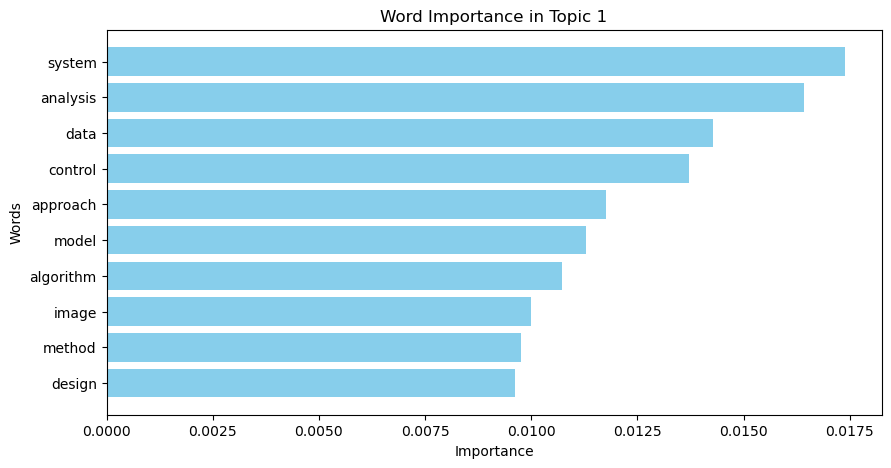

In [76]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(-1)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 1')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_1.png')

# Show the plot
plt.show()

In [83]:
topic_model.get_topic(0)

[('paper', 0.017105992246671763),
 ('data', 0.015415838883285467),
 ('system', 0.015310421116786353),
 ('model', 0.01356756659143876),
 ('information', 0.012752813662001245),
 ('approach', 0.011028620593010558),
 ('results', 0.010796995806910766),
 ('design', 0.010266289264962127),
 ('network', 0.01014538979950271),
 ('method', 0.010138137745069753)]

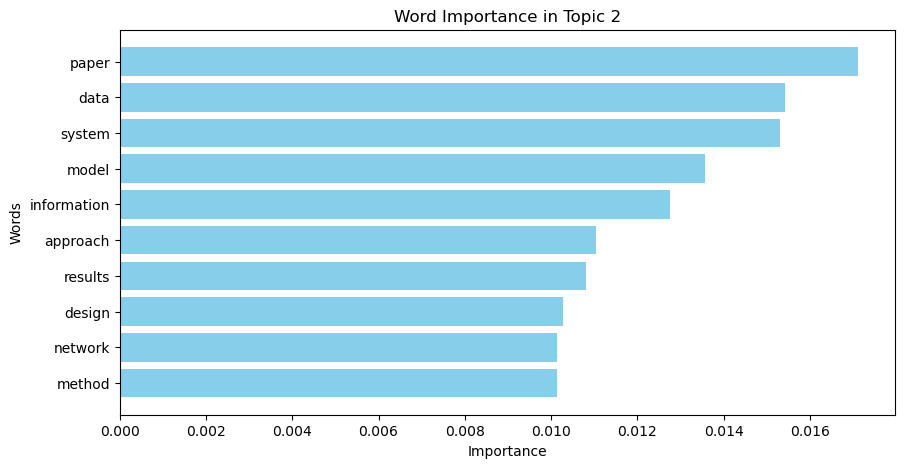

In [84]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(0)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 2')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_2.png')

# Show the plot
plt.show()

In [86]:
topic_model.get_topic(1)

[('robot', 0.12754607775083457),
 ('control', 0.09444962217961037),
 ('robots', 0.07607138279710873),
 ('motion', 0.052905367133022116),
 ('robotic', 0.05231642055518148),
 ('autonomous', 0.046798605046684455),
 ('mobile', 0.03959664811245876),
 ('mobile robot', 0.03140980773571938),
 ('robotics', 0.02656625836696522),
 ('navigation', 0.02644928069689864)]

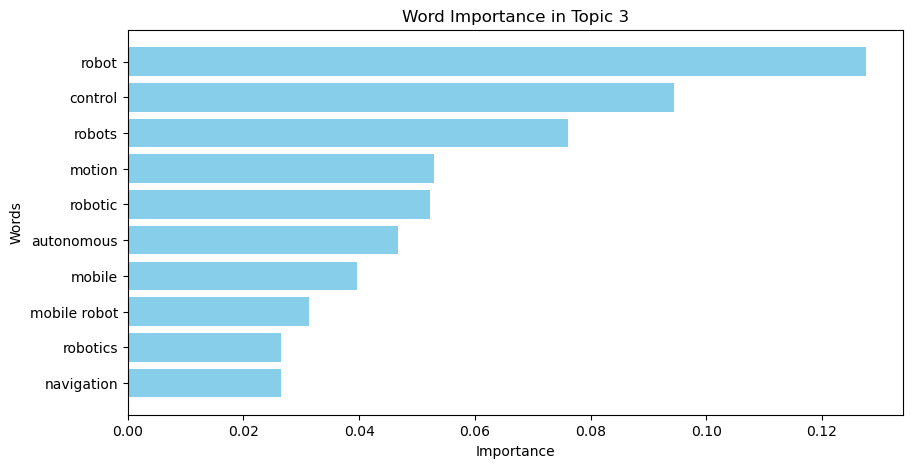

In [78]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(1)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 3')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_3.png')

# Show the plot
plt.show()

In [87]:
topic_model.get_topic(2)

[('editorial', 0.5987400885650871),
 ('preface', 0.3231680658191218),
 ('editorial editorial', 0.18676163096222861),
 ('preface editorial', 0.06993584599364365),
 ('title', 0.0663638503111777),
 ('section', 0.05632998577397608),
 ('awards', 0.048514107059531804),
 ('foreword', 0.048514107059531804),
 ('editorial pointers', 0.048514107059531804),
 ('editorial awards', 0.048514107059531804)]

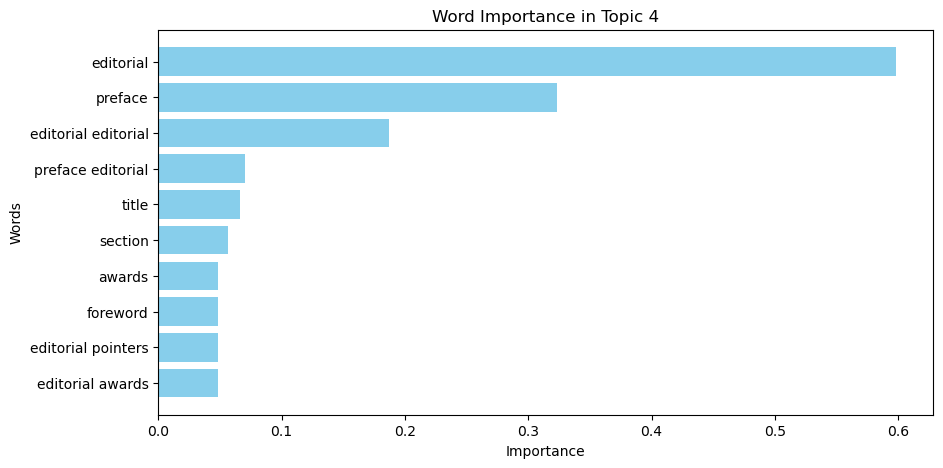

In [79]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(2)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 4')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_4.png')

# Show the plot
plt.show()

In [88]:
topic_model.get_topic(3)

[('speech', 0.14662109032074835),
 ('recognition', 0.09733325580087909),
 ('music', 0.08771555169178005),
 ('speech recognition', 0.06979473059144112),
 ('audio', 0.06129700772673948),
 ('acoustic', 0.0513562314216801),
 ('speaker', 0.048604639034860245),
 ('sound', 0.04511989317377911),
 ('identification', 0.04404790357539248),
 ('emotion', 0.04032417884641435)]

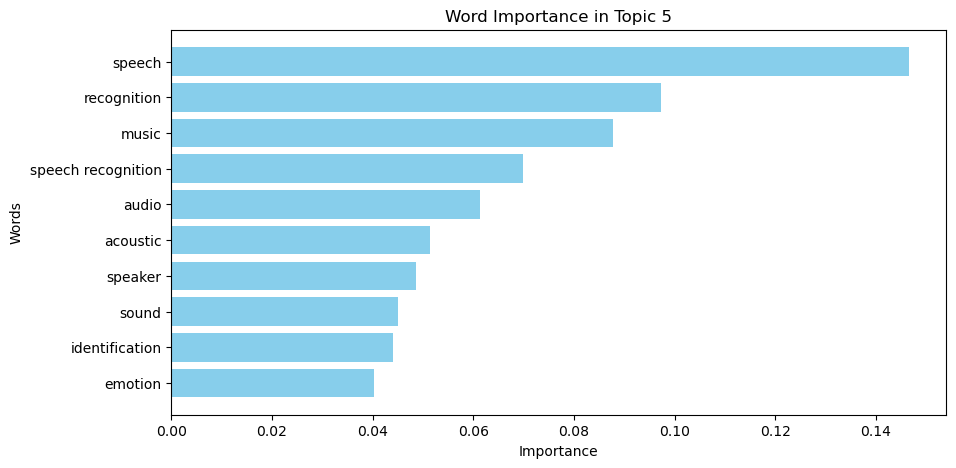

In [80]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(3)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 5')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_5.png')

# Show the plot
plt.show()

In [89]:
topic_model.get_topic(4)

[('ultrasound', 0.10959409444648421),
 ('imaging', 0.08081768376867442),
 ('mri', 0.06913858502447782),
 ('ct', 0.06391851059725277),
 ('images', 0.06027294104992037),
 ('digital', 0.053018094092395274),
 ('diagnostic', 0.05113480847780222),
 ('segmentation', 0.049728390414809726),
 ('automatic', 0.0453601249293543),
 ('therapy', 0.044820501563153425)]

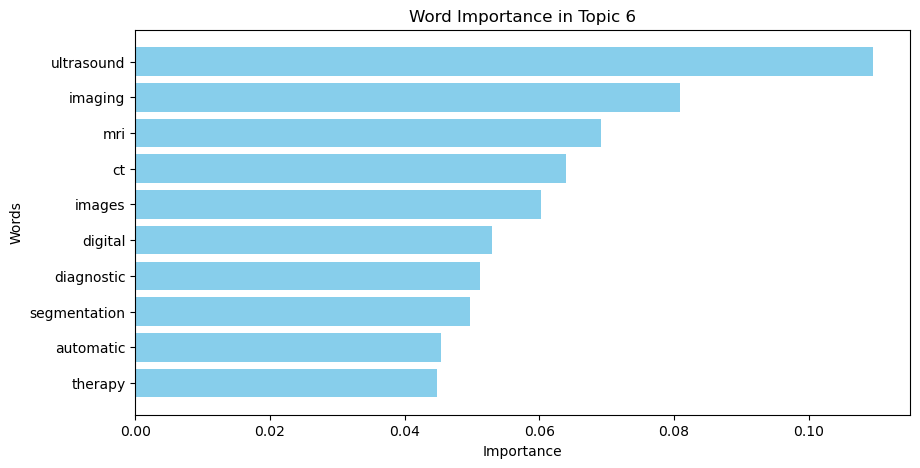

In [81]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(4)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 6')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_6.png')

# Show the plot
plt.show()

In [90]:
topic_model.get_topic(5)

[('face', 0.4138141429223734),
 ('face recognition', 0.28202563194386154),
 ('recognition', 0.27061169606310687),
 ('facial', 0.18801708796257433),
 ('expression recognition', 0.08646247242441824),
 ('multiview', 0.08397543825942586),
 ('identification', 0.07203799792229174),
 ('extraction', 0.06918735827924634),
 ('facial expression', 0.05997853581711568),
 ('multiview face', 0.05997853581711568)]

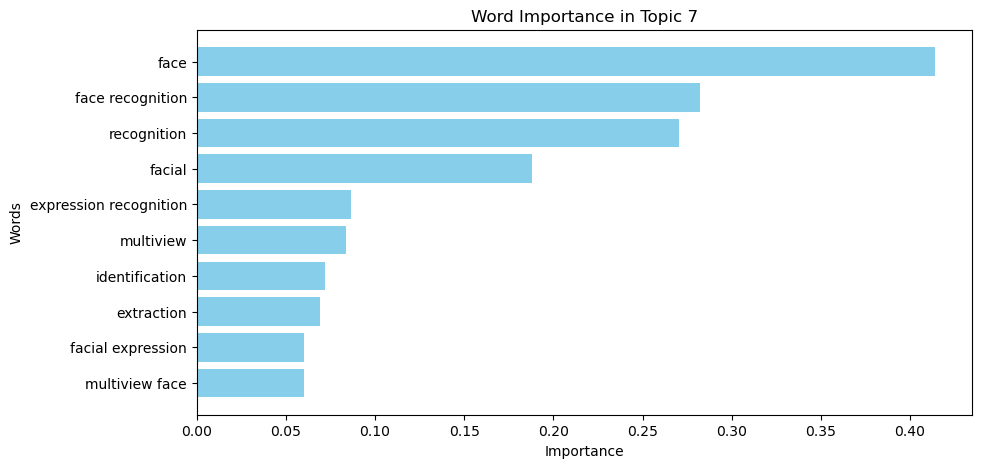

In [82]:
import matplotlib.pyplot as plt

# Define the list of words and their corresponding frequencies
words = topic_model.get_topic(5)

# Separate the words and their frequencies
word_labels, word_importance = zip(*words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.barh(word_labels, word_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Word Importance in Topic 7')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Save the plot as a PNG file
plt.savefig('word_importance_topic_7.png')

# Show the plot
plt.show()

In [74]:
# Get the document-topic matrix
document_topic_matrix = topic_model.transform(docs)

# Identify the dominant topic for each document
dominant_topics = document_topic_matrix[0]

# Create a new column to store the assigned topics
citation['assigned_topic'] = dominant_topics

Batches:   0%|          | 0/379 [00:00<?, ?it/s]

2024-04-22 13:32:47,184 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-04-22 13:32:47,250 - BERTopic - Dimensionality - Completed ✓
2024-04-22 13:32:47,251 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-04-22 13:32:47,732 - BERTopic - Cluster - Completed ✓


In [98]:
def name_topic(row):
    topic = "Unknown"
    if row == 0 or row == -1:
        topic = "Data System Analysis and Design"
    elif row == 1:
        topic = "Robotics"
    elif row ==2:
        topic = "Editorial Content and Prefaces"
    elif row == 3:
        topic = "Speech and Audio Processing"
    elif row ==4:
        topic = "Medical Imaging and Diagnostic Techniques"
    elif row == 5:
        topic = "Facial Recognition"
    return topic
citation["assigned_topic_name"] = citation["assigned_topic"].apply(name_topic)

In [99]:
citation.head()

,title,authors,year,venue,id,references,abstract,ISCITED_COUNT,AUTHOR_COUNT,REF_COUNT,MAIN_AUTHOR,SECONDARY_AUTHORS,TITLE_TOKEN,ABSTRACT_TOKEN,assigned_topic,assigned_topic_name
0,Securing communication using function extracti...,['K. Vimal Kumar'],2009,Computers Security,1587640,[],NaN,0,1,0,K. Vimal Kumar,[],"['securing', 'communication', 'using', 'functi...",[],0,Data System Analysis and Design
1,Compressing Data Cube in Parallel OLAP Systems,"['Frank K. H. A. Dehne', 'Todd Eavis', 'Boyong...",2007,Data Science Journal,839971,[],NaN,0,3,0,Frank K. H. A. Dehne,"['Todd Eavis', 'Boyong Liang']","['compressing', 'data', 'cube', 'in', 'paralle...",[],0,Data System Analysis and Design
2,Distributed Resource Administration Using Cfen...,"['Mark Burgess', 'Ricky Ralston']",1997,Softw Pract Exper,1073637,[],NaN,15,2,0,Mark Burgess,['Ricky Ralston'],"['distributed', 'resource', 'administration', ...",[],-1,Data System Analysis and Design
3,Existence of positive solutions of BVPs for se...,"['Wan-Tong Li', 'Ming-Fei Niu', 'Jian-Ping Sun']",2004,Applied Mathematics and Computation,1280289,[],NaN,0,3,0,Wan-Tong Li,"['Ming-Fei Niu', 'Jian-Ping Sun']","['existence', 'of', 'positive', 'solutions', '...",[],0,Data System Analysis and Design
4,Integrating Searching and Authoring in Mizar,"['Paul A. Cairns', 'Jeremy Gow']",2007,J Autom Reasoning,955214,"['595127', '954818', '612606', '893021', '5009...",The vision of a computerized assistant to math...,0,2,10,Paul A. Cairns,['Jeremy Gow'],"['integrating', 'searching', 'and', 'authoring...","['the', 'vision', 'of', 'a', 'computerized', '...",0,Data System Analysis and Design


In [100]:
citation["assigned_topic_name"].value_counts()

assigned_topic_name
Data System Analysis and Design              11555
Robotics                                       230
Editorial Content and Prefaces                 142
Speech and Audio Processing                     93
Medical Imaging and Diagnostic Techniques       50
Facial Recognition                              31
Name: count, dtype: int64

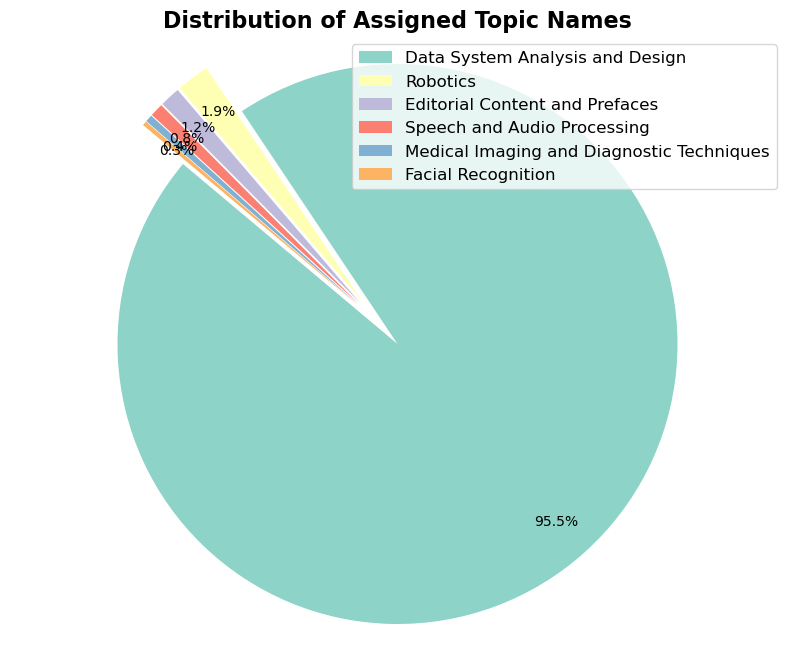

In [110]:
import matplotlib.pyplot as plt

# Get the value counts of the "assigned_topic_name" column
topic_counts = citation["assigned_topic_name"].value_counts()

# Define colors for the pie chart slices
colors = plt.cm.Set3.colors[:len(topic_counts)]

# Create a pie chart
plt.figure(figsize=(10, 8))

plt.pie(topic_counts, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85, explode=[0.1]*len(topic_counts))
plt.title('Distribution of Assigned Topic Names', fontsize=16, fontweight='bold')

# Add legend
plt.legend(topic_counts.index, loc="best", fontsize=12)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Set background color
plt.gca().set_facecolor('#f5f5f5')

# Show the plot
plt.savefig('pie_chart_assigned_topics.png')
plt.show()

In [108]:
citation.to_csv("cleaned_data_with_topics.csv")